#  Прогнозирование заказов такси

Текущее исследование производится в интересах сервиса по заказу такси в рамках перевозок посетителей аэропорта

**Цель исследования:** построить модель, которая с достаточной точностью предсказывала бы количество заказов в пиковые часы для определения необходимого количества дополнительно привлекаемых водителей такси.

Предоставлены исторические данные о заказах такси в аэропортах в файле `taxi.csv`.

**Ограничения исследования:**
1. Перед обученеим моделей следует провести:
    * ресемплирование данных по одному часу
    * анализ данных
2. Тестовую выборку следует сделать размером 10% от исходных данных
3. Значение метрики RMSE должно быть меньше 48

**Ход исследования:**  
Наше исследование будет проходить в шесть этапов:  
1. Загрузка, обзор и предобработка данных
2. Ресемплирование и анализ данных
3. Обучение моделей и подбор гиперпараметров
4. Тестирование выбранной модели и проверка ее на адекватность
5. Подготовка общего вывода


**Описание данных**  
* **Признаки**  
    - **datetime** — время
* **Целевой признак**  
    - **num_orders** — количество заказов
    
    
_______________________

Для начала импортируем библиотеки и зафиксируем глобальные константы:

In [1]:
# pip install pmdarima

In [2]:
# pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import warnings  
import time  

import pmdarima as pm  # Для подбора параметров модели SARIMA

import seaborn as sns  
import matplotlib.pyplot as plt  

from statsmodels.tsa.seasonal import seasonal_decompose  # Для опрееделения сезонности
from statsmodels.tsa.stattools import adfuller  # Тест Дики — Фуллера на статичность

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  # к-т детерминации

from sklearn.model_selection import train_test_split  # импортируем метод для выделения выборок
from sklearn.model_selection import TimeSeriesSplit  # импортируем метод для подготовки к кросс-валидации

from sklearn.tree import DecisionTreeRegressor  # дерево решений
from sklearn.linear_model import LinearRegression  # линейная регрессия
from lightgbm import LGBMRegressor  # lightgbm регрессия

from sklearn.model_selection import RandomizedSearchCV  # Рандомизированный поиск модели по параметрам

In [4]:
# Общие константы:
MODE = '' 
MODE = 'check' 
# Константа-рычаг для проверки работы. Включает оптимальные гиперпараметры для моделей и выключает логирование. 
# Если закомментить, то будет включен перерасчет. 
# MODE = 'check' -- включено.
# Всё остальное -- выключено.

RAND_FIX = 12345  # Зафиксируем random_state

In [5]:
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Шаг 1 Подготовка данных

### 1.1 Открыть и изучить данные

In [6]:
try:
    # загружаем с локального хранилища
    d_taxi = pd.read_csv('datasets/taxi.csv', sep=',', parse_dates=True, index_col='datetime') 
    
    print('*' * 50, 'Исторические данные о заказах такси в аэропортах', sep='\n')
    display(d_taxi.head(5))
    print()
    d_taxi.info()

except:
    # загружаем из хранилища Яндекс
    d_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', sep=',', parse_dates=True, index_col='datetime') 
    
    print('Файл загружен из хранилища Яндекс')
    print('*' * 50, 'Исторические данные о заказах такси в аэропортах', sep='\n')
    display(d_taxi.head(5))
    print()
    d_taxi.info()

**************************************************
Исторические данные о заказах такси в аэропортах


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Посмотрим, сохраняется ли разница между записями в десять минут на протяжении всего датафрейма:

In [7]:
print(pd.Series((d_taxi.iloc[1:].index - d_taxi.iloc[:len(d_taxi)-1].index)).sort_values())

0       0 days 00:10:00
17668   0 days 00:10:00
17667   0 days 00:10:00
17666   0 days 00:10:00
17665   0 days 00:10:00
              ...      
8826    0 days 00:10:00
8825    0 days 00:10:00
8824    0 days 00:10:00
8834    0 days 00:10:00
26494   0 days 00:10:00
Name: datetime, Length: 26495, dtype: timedelta64[ns]


Теперь посмотрим пристально на целевой признак:

,num_orders
count,26496.00
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


Text(0.5, 0, 'Значение целевого признака')

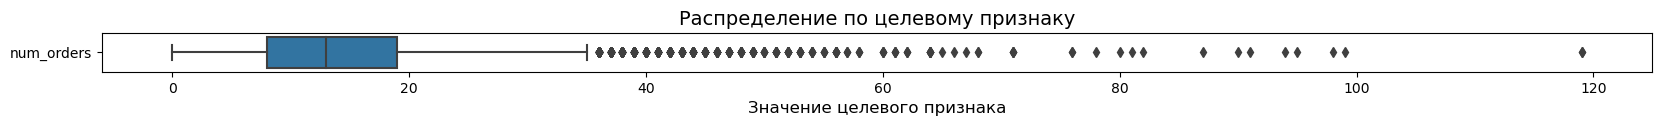

In [8]:
display(d_taxi.describe().round(2))
fig, ax = plt.subplots(figsize=(20, 0.5))
ax = sns.boxplot(data=d_taxi, orient='h')
ax.set_title('Распределение по целевому признаку', fontsize=14)
ax.set_xlabel('Значение целевого признака', fontsize=12)

**Промежуточные выводы.**

1. Наименования колонок -- ОК
2. В файле обнаружены данные по количеству заказов такиси за шесть месяцев с первого марта по тридцать первое августа 2018 года с шагом 10 минут
3. Разница между записями в десять минут сохраняется на протяжении всего датафрейма
4. Распределение значений "num_orders" похоже на реальность -- большая часть заказов в диапазаоне от восьми до девятнадцати за десять минут, есть выбросы до 119-и заказов, но, на мой взгляд, это количество всё ещё не покушается на реалистичность.

Итого: классическая предобработка данных не требуется.

## Шаг 2 Ресемплирование и анализ данных

### 2.1 Ресемплирование по одному часу

Заказчика интересуют данные за следующий час, поэтому проведем ресемплирование

In [9]:
d_taxi = d_taxi.resample('1H').sum()

### 2.2 Общий анализ распределения, скользящее среднее

Здесь и далее основное внимание окажем августу как наиболее влиятельному периоду:

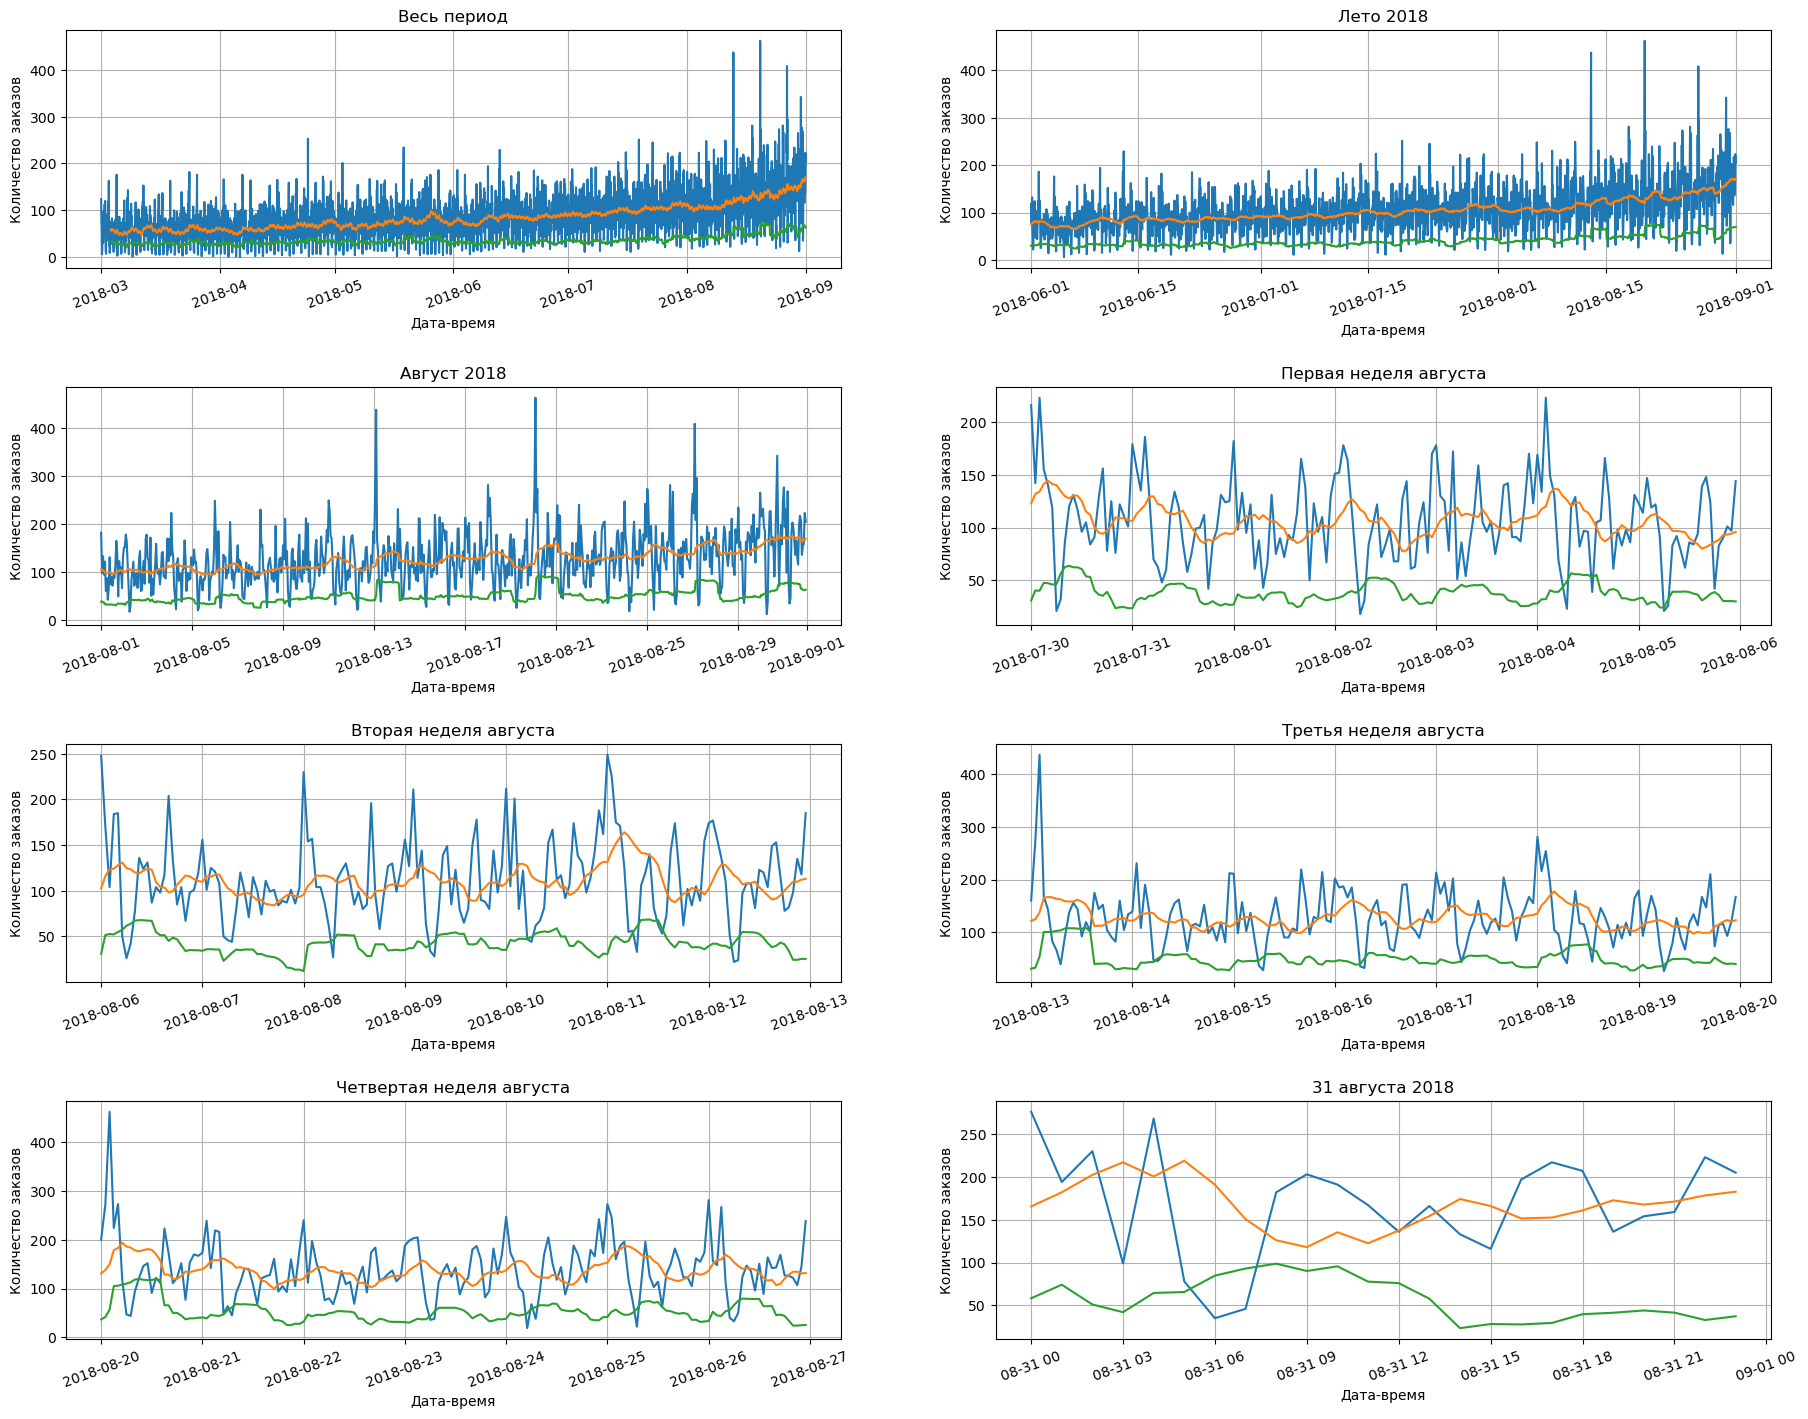

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,17))
plt.subplots_adjust(hspace=0.5)


params = [['2018-03-01', '2018-08-31', 60, 'Весь период'],
         ['2018-06-01', '2018-08-31', 48, 'Лето 2018'],
         ['2018-08-01', '2018-08-31', 24, 'Август 2018'],
         ['2018-07-30', '2018-08-05', 12, 'Первая неделя августа'], 
         ['2018-08-06', '2018-08-12', 12, 'Вторая неделя августа'],
         ['2018-08-13', '2018-08-19', 12, 'Третья неделя августа'],
         ['2018-08-20', '2018-08-26', 12, 'Четвертая неделя августа'],
         ['2018-08-31', '2018-08-31', 6, '31 августа 2018'],]

for i in range(8):
    x = i // 2
    y = i % 2
    d_taxi['r_mean'] = d_taxi.num_orders.rolling(params[i][2], closed='left').mean() 
    d_taxi['r_std'] = d_taxi.num_orders.rolling(params[i][2], closed='left').std() 
    ax[x,y].plot(d_taxi[params[i][0] : params[i][1]])
    ax[x,y].set_title(params[i][3])
    ax[x,y].tick_params(axis='x', labelrotation = 20)
    ax[x,y].grid()
    ax[x,y].set_xlabel('Дата-время')
    ax[x,y].set_ylabel('Количество заказов')

In [11]:
d_taxi = d_taxi.drop(['r_mean', 'r_std'], axis=1)

Посмотрим внимательно на выбросы, которые видны на графике за август:

In [12]:
display(d_taxi.sort_values('num_orders', ascending=False).head())
print('Дни недели с выбросами:', list(pd.DatetimeIndex(d_taxi.sort_values('num_orders', ascending=False).head().index).weekday))

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295


Дни недели с выбросами: [0, 0, 0, 3, 0]


Что видно сразу:
1. Растущий тренд, начиная с лета, причем в августе наиболее активно
2. Очень слабый рост дисперсии на всем периоде
3. Существуют пики около полуночи, спады около шести утра, сутки -- очевидный кандидат на самую сильную сезонность
3. В выбросах лидеры -- понедельники, значит, когда мы будем исследовать сезонность, следует не игнорировать зависимость от дней недели

Посмотрим внимательнее на тренд, сезонность и остатки:

### 2.3 Тренд, сезонность и остатки

Особо пристально посмотрим на август.

Судя по распределению, именно занчения в рамках этого месяца имеют наибольшее влияние на прогноз.

In [13]:
decomposed = seasonal_decompose(d_taxi)

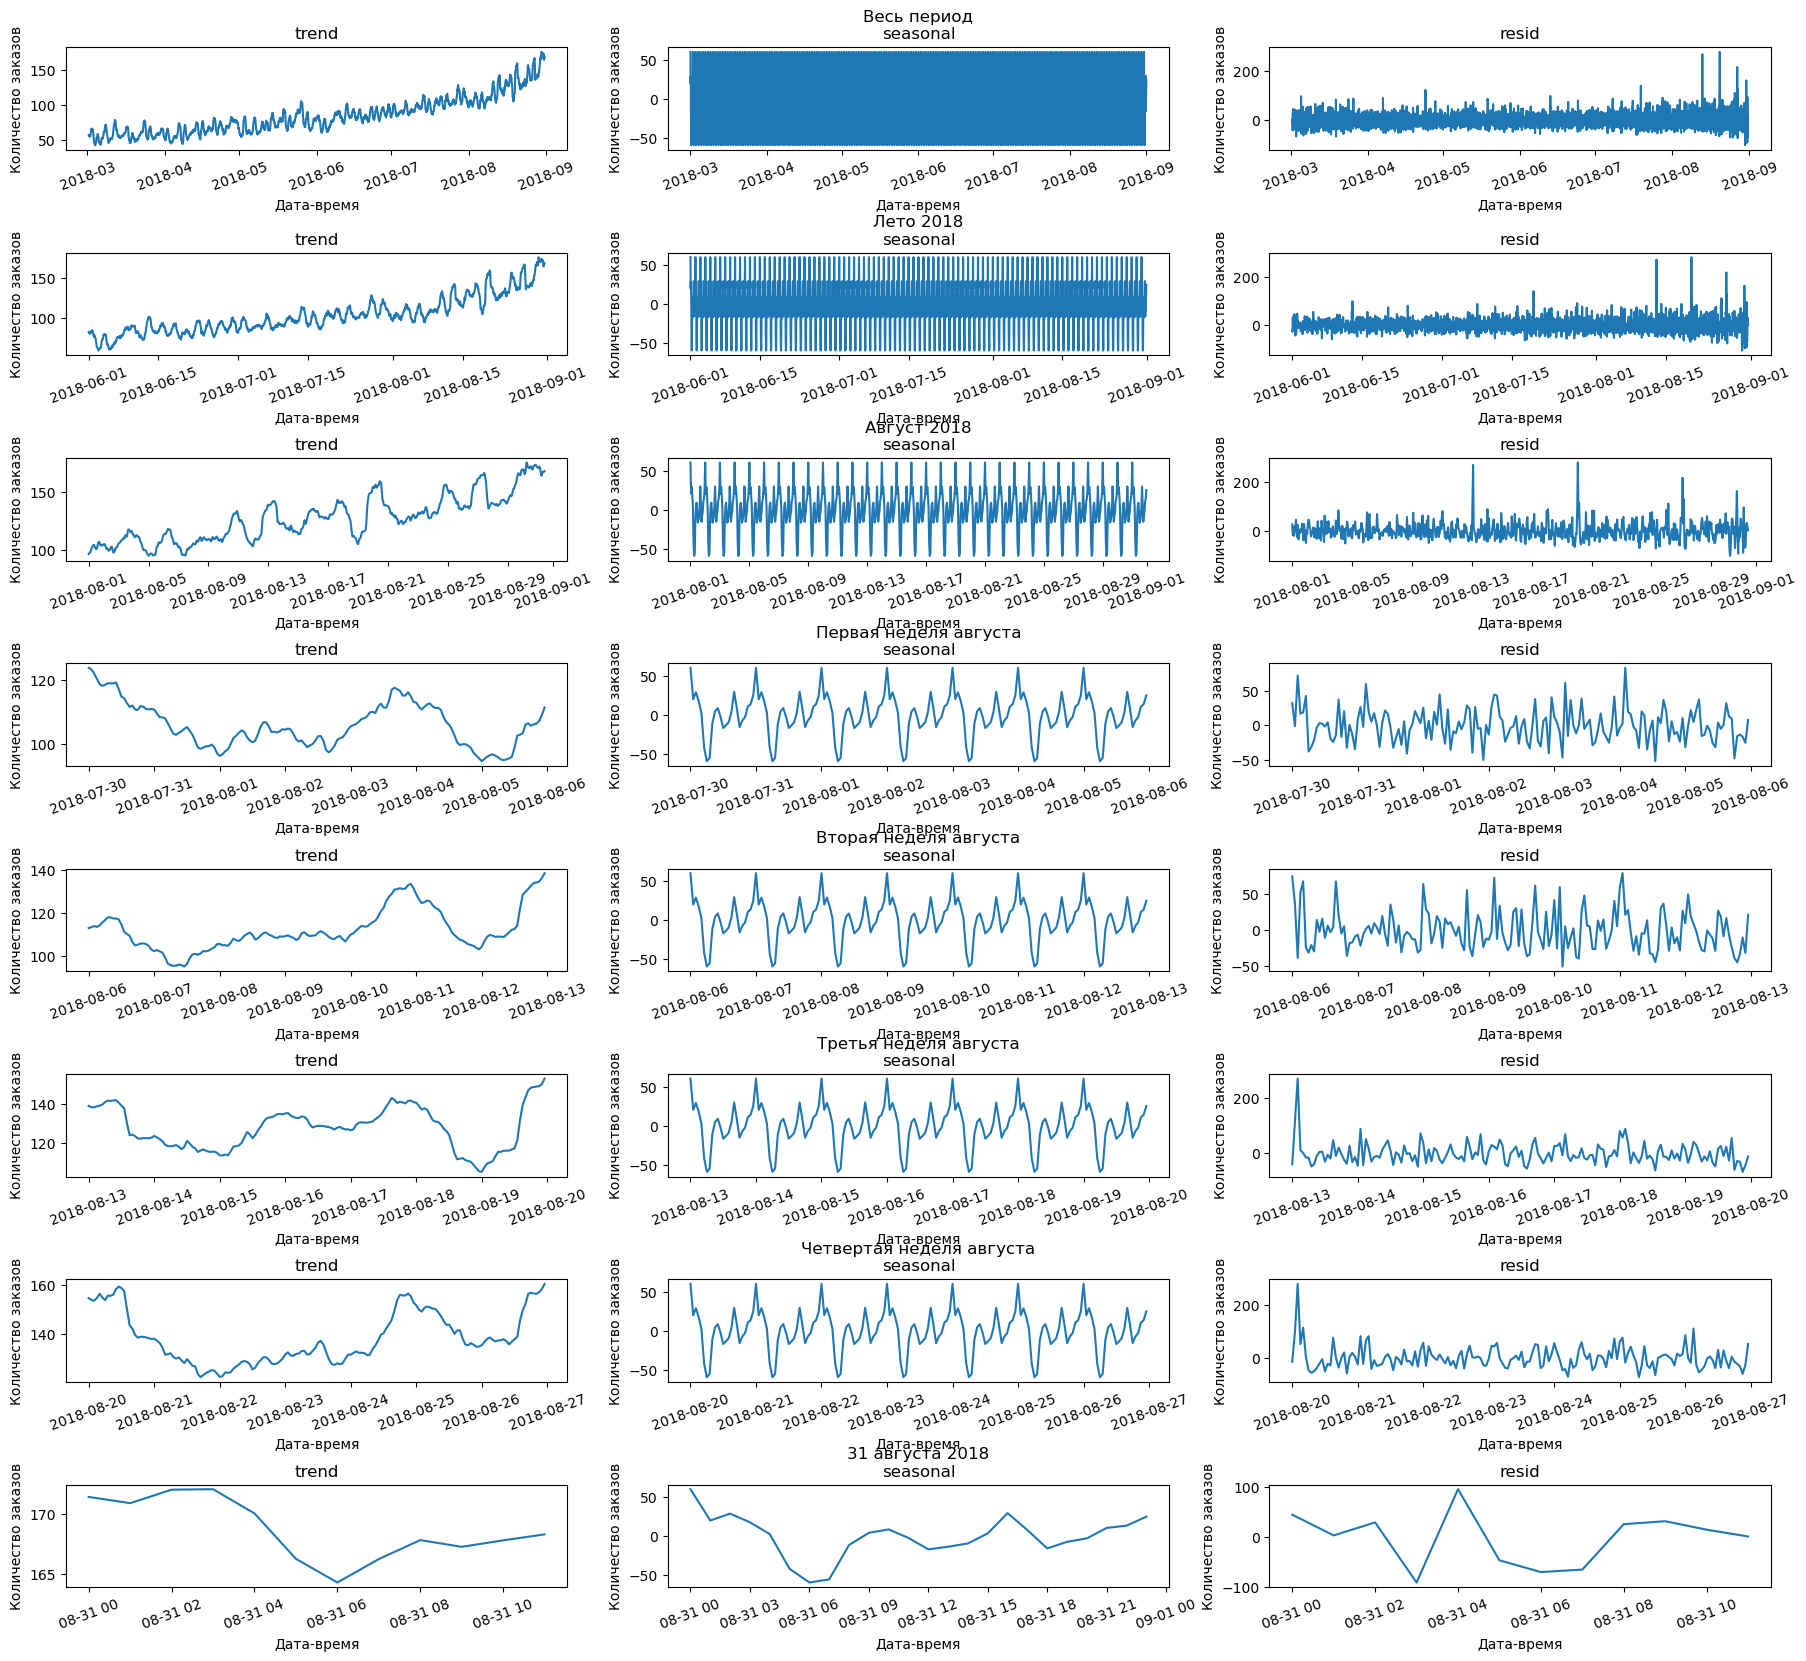

In [14]:
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(22,20))
plt.subplots_adjust(hspace=1)

params = [['2018-03-01', '2018-08-31', 'Весь период'],
         ['2018-06-01', '2018-08-31', 'Лето 2018'],
         ['2018-08-01', '2018-08-31', 'Август 2018'],
         ['2018-07-30', '2018-08-05', 'Первая неделя августа'], 
         ['2018-08-06', '2018-08-12', 'Вторая неделя августа'],
         ['2018-08-13', '2018-08-19', 'Третья неделя августа'],
         ['2018-08-20', '2018-08-26', 'Четвертая неделя августа'],
         ['2018-08-31', '2018-08-31', '31 августа 2018'],]

for i in range (8):
    ax[i, 0].plot(decomposed.trend[params[i][0] : params[i][1]])
    ax[i, 0].set_title('trend')
    ax[i, 0].set_xlabel('Дата-время')
    ax[i, 0].set_ylabel('Количество заказов')
    ax[i, 0].tick_params(axis='x', labelrotation = 20)
    ax[i, 1].plot(decomposed.seasonal[params[i][0] : params[i][1]])
    title = params[i][2] + '\nseasonal'
    ax[i, 1].set_title(title)
    ax[i, 1].set_xlabel('Дата-время')
    ax[i, 1].set_ylabel('Количество заказов')
    ax[i, 1].tick_params(axis='x', labelrotation = 20)
    ax[i, 2].plot(decomposed.resid[params[i][0] : params[i][1]])
    ax[i, 2].set_title('resid')
    ax[i, 2].set_xlabel('Дата-время')
    ax[i, 2].set_ylabel('Количество заказов')
    ax[i, 2].tick_params(axis='x', labelrotation = 20)

Пока очевидна ежесуточноя сезонность и более слабо выраженная еженедельная сезонность.

Суточная динамика:
1. Максимальный пик около полуночи
2. Спад с трех до шести утра до ежедневного минимума
3. Рост до первого локального максисума к двевяти утра
4. Плато до трёх дня, после чего -- рост до второго локального максимума в пять часов дня
5. Второе плато с семи до девяти вечера
6. Рост значений к полуночному максимуму после девяти

Еженедельная динамика:

1. Основной пик -- в ночь с воскресенья на понедельник
2. Второй по величине локальный максимум -- в ночь с пятницы на субботу
3. В рамках рабочих дней особой постоянной закономерности на прослеживается

Причины, на мой звзгляд, очевидны -- активность вызовов такси в аэропортах зависит от расписания пассажирских авиаперевозок, которые в свою очередь имеют свою периодичность. Подозреваю, что большинство пассажиров перемещаются на регулярных, а не на чартерных рейсах.

С другой стороны, наш тренд на рост к концу августа может оказаться ежегодной сезонностью, если посмотреть данные за несколько лет. Люди едут в отпуск, появляется больше чартера, например. Проблема в том, что мы не знаем:
1. что за аэропорт обслуживается
2. что происходит с августа по март  

Поэтому, предлагаю не плодить сущности и остаться в рамках парадигмы плавно растущего числа заказов такси.

### 2.4 Стационарность и разности временного ряда

Судя по графикам, наш ряд не стационарен.  
Попробуем наши пробления измерить с помощью теста Дики — Фуллера.

**Нулевая гипотеза**: временной ряд является нестационарным  
**Альтернативная гипотеза**: временной ряд является стационарным

In [15]:
print('p-value на полной выборке равно:', round(adfuller(d_taxi)[1], 3))

p-value на полной выборке равно: 0.029


Если $\alpha = 0.01$, то гипотезу отвергаем, ряд не считаем стационарным, $\alpha = 0.05$. Значение пограничное, посмотрим на увеличении, как ведет себя скользящее среднее на всем периоде:

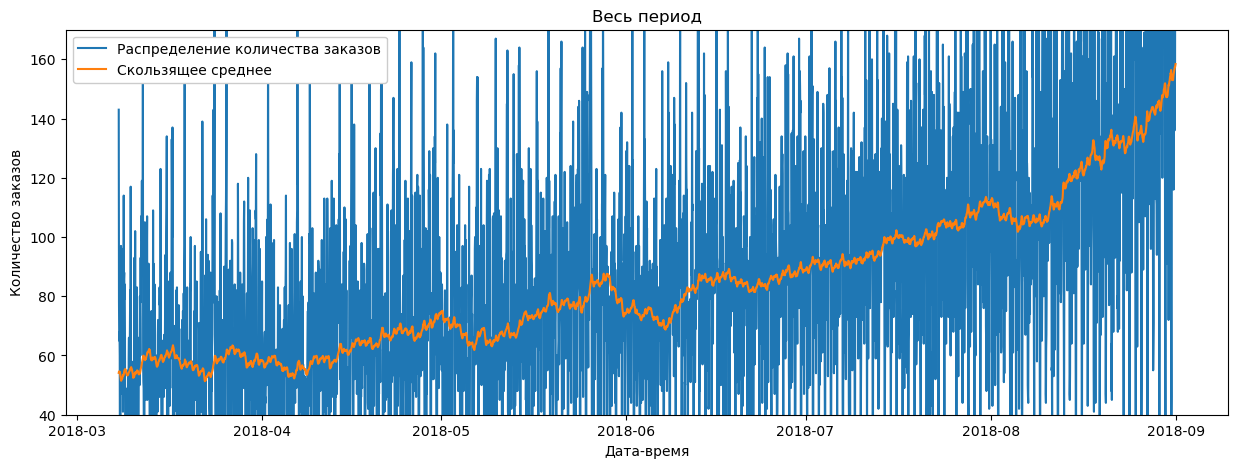

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

d_taxi['r_mean'] = d_taxi.num_orders.rolling(128, closed='left').mean()
ax.plot(d_taxi['2018-03-08' : ], label=['Распределение количества заказов', 'Скользящее среднее'])
ax.set_title('Весь период')
ax.set_xlabel('Дата-время')
ax.set_ylabel('Количество заказов')
ax.set_ylim(40, 170)
ax.legend(framealpha=1)

d_taxi = d_taxi.drop(['r_mean'], axis=1)

Среднее, очевидно, растет => наш ряд не является стационарным.

Так или иначе, посмотрим, какой уровень сдвига для разности временного ряда максимально снизит $p-value$.

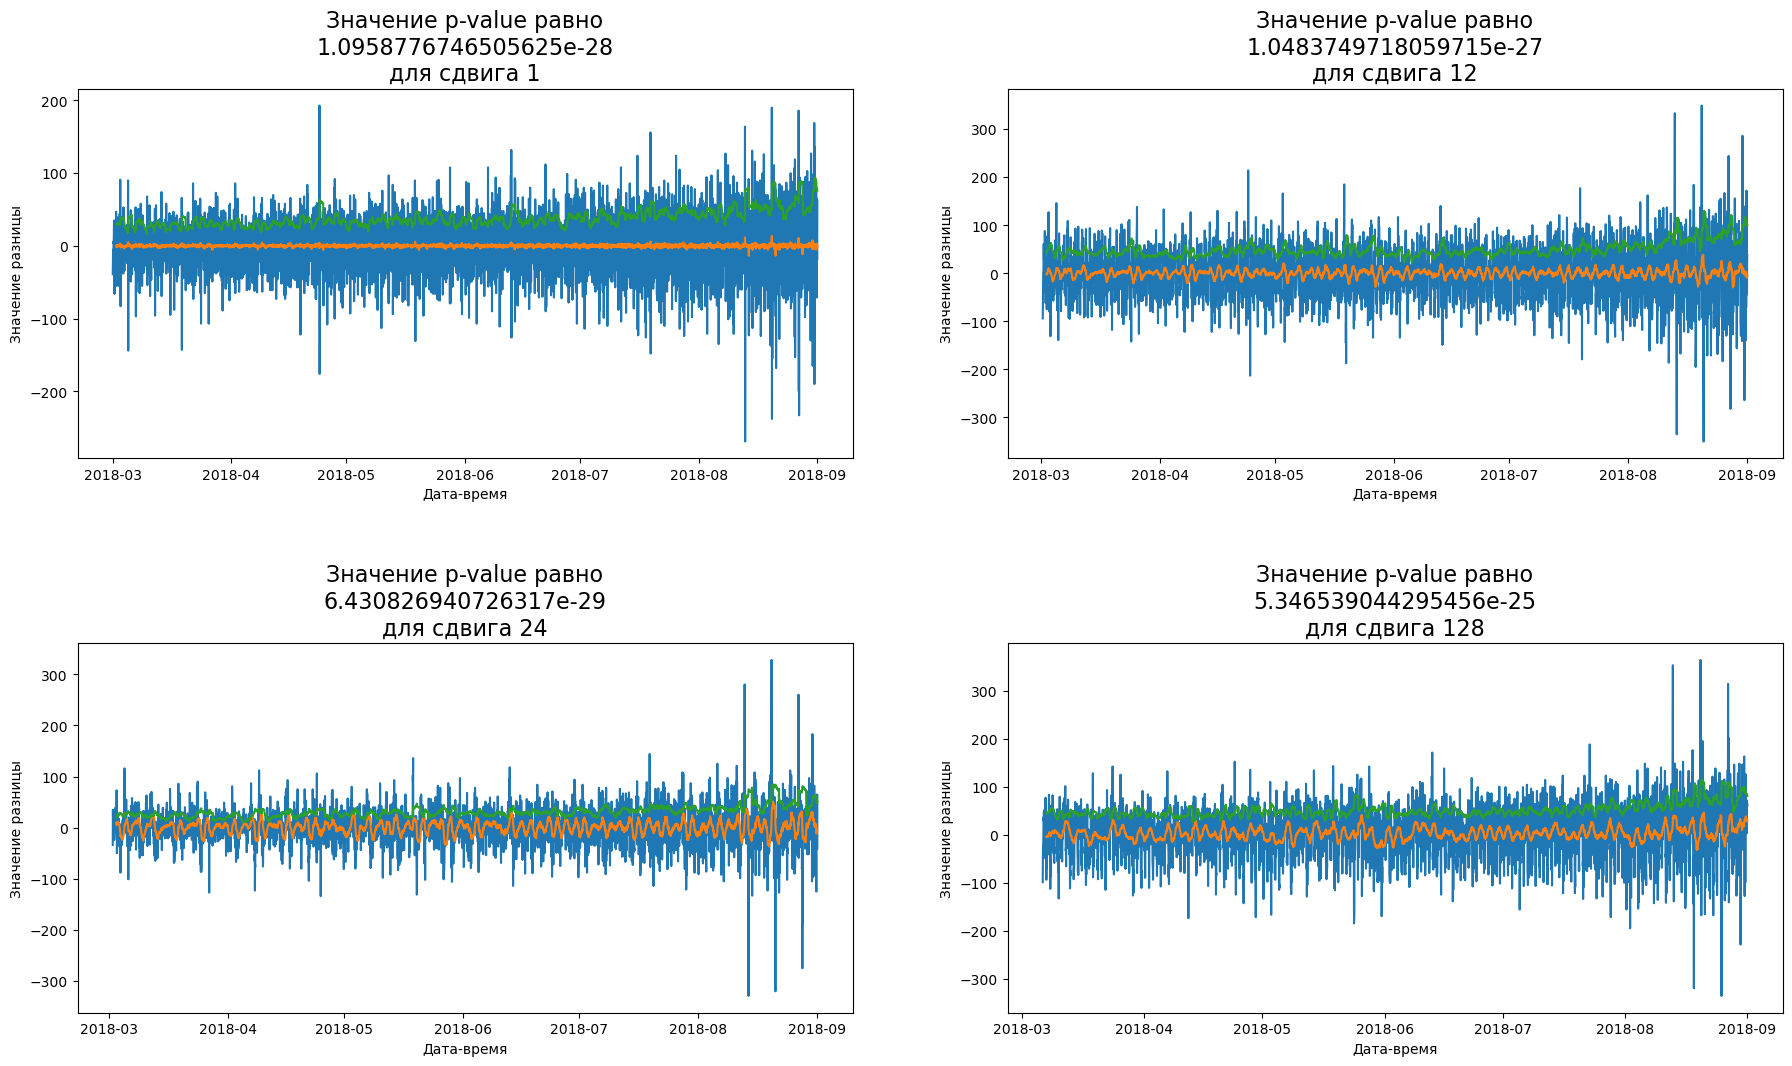

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,12))
plt.subplots_adjust(hspace=0.5)
count = 0

for i in [1, 12, 24, 128]:
    d_taxi_diff = d_taxi - d_taxi.shift(i)   
    d_taxi_diff['r_mean'] = d_taxi_diff['num_orders'].rolling(24).mean()
    d_taxi_diff['r_std'] = d_taxi_diff['num_orders'].rolling(24).std()
    ax[count // 2, count % 2].plot(d_taxi_diff)
    title = 'Значение p-value равно\n' + str(adfuller(d_taxi_diff['num_orders'].dropna())[1]) + '\nдля сдвига ' + str(i)
    ax[count // 2, count % 2].set_title(title, fontsize=16)
    ax[count // 2, count % 2].set_xlabel('Дата-время')
    ax[count // 2, count % 2].set_ylabel('Значение разницы')
    count += 1

Наименьшее значение $p-value$ достигается на суточном сдвиге.

Промежуточные выводы по шагу "Анализ":
1. Обнаружен слабый тренд вверх
2. Обнаружена двухуровневая сезонность -- сильная ежесуточная и еженедельная, которая выражена слабее
3. Наш временной ряд является нестационарным

## Шаг 3 Обучение моделей и подбор гиперпараметров

Попробуем два варианта:
1. Генерация признаков и использование привычных регрессоров
2. Модель SARIMA

### 3.1 Обучение регерссоров

#### 3.1.1 Функция генерации признаков

In [18]:
def make_features(data, target, max_lag, rolling_mean_size):

    d_loc = data.copy()
    d_loc['day'] = d_loc.index.day
    d_loc['dayofweek'] = d_loc.index.dayofweek
    d_loc['hour'] = d_loc.index.hour
        
    for lag in range(1, max_lag + 1):
        d_loc['lag_{}'.format(lag)] = d_loc[target].shift(lag)

    d_loc['rolling_mean'] = d_loc[target].shift().rolling(rolling_mean_size).mean()
    
    return d_loc


#### 3.1.2 Обучение моделей и подбор гиперпараметров

Костыль для проверки работы:

In [19]:
if MODE == 'check':
    
    tree_depth_min, tree_depth_max = 6, 7
    tree_iter = 1
    
    lgb_iter_min, lgb_iter_max = 50, 51
    lgb_depth_min, lgb_depth_max = 120, 121
    lgb_leaves_min, lgb_leaves_max = 220, 221
    lgb_iter = 1
    lgb_verb = -1
    
    verb = 0
    
else:
    
    tree_depth_min, tree_depth_max = 3, 30
    tree_iter = 10
    
    lgb_iter_min, lgb_iter_max = 50, 851
    lgb_depth_min, lgb_depth_max = 30, 121
    lgb_leaves_min, lgb_leaves_max = 20, 321
    lgb_iter = 10
    lgb_verb = -1
    
    verb = 10

Подберем гиперпараметры моделей и измерим время на обучение:

In [20]:
best_model_for_l = None
best_result_for_l = 5000
best_fit_time_for_l = 0
best_prep_time_for_l = 0

best_model_for_t = None
best_result_for_t = 5000
best_depth_for_t = 0
best_fit_time_for_t = 0
best_prep_time_for_t = 0

best_model_for_gbm = None
best_result_for_gbm = 5000
best_num_iterations_for_gbm = 0
best_max_depth_for_gbm = 0
best_num_leaves_for_gbm = 0
best_fit_time_for_gbm = 0
best_prep_time_for_gbm = 0

for m_l in range(6, 25, 6):
    for r_m_s in range(6, 25, 3):
        
#         Генерим признаки
        df = d_taxi.copy()
        df = make_features(df, 'num_orders', m_l, r_m_s)
        
#         Готовим выборки
        tss = TimeSeriesSplit(n_splits = 5)
        
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        
#         Готовим параметры
        param_for_l = {}
        param_for_t = {'max_depth' : range(tree_depth_min, tree_depth_max)}
        param_for_gbm = {'num_iterations' : range(lgb_iter_min, lgb_iter_max, 200), \
                         'max_depth' : range(lgb_depth_min, lgb_depth_max, 30), \
                         'num_leaves' : range(lgb_leaves_min, lgb_leaves_max, 50), \
                         'metric' : ['rmse'], 'verbosity' : [lgb_verb]}
        
#         Определяем рандомизаторы
        grid_model_l = RandomizedSearchCV(LinearRegression(), param_distributions = param_for_l, \
                                    n_iter=1, cv=tss, scoring='neg_mean_squared_error', \
                                          random_state=RAND_FIX, verbose=verb)
        grid_model_t = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions = param_for_t, \
                                            n_iter=tree_iter, cv=tss, scoring='neg_mean_squared_error', \
                                          random_state=RAND_FIX, verbose=verb)
        grid_model_gbm = RandomizedSearchCV(LGBMRegressor(), param_distributions = param_for_gbm, \
                                            n_iter=lgb_iter, cv=tss, scoring='neg_mean_squared_error', \
                                            random_state=RAND_FIX, verbose=verb)

#         Обучаем модели
        grid_model_l.fit(features_train, target_train)
        result = abs(grid_model_l.best_score_) ** 0.5
        if result < best_result_for_l:
            best_result_for_l = result
            best_model_for_l = grid_model_l
            best_fit_time_for_l = grid_model_l.refit_time_
            best_m_l_for_l = m_l
            best_r_m_s_for_l = r_m_s
        
        grid_model_t.fit(features_train, target_train)
        result = abs(grid_model_t.best_score_) ** 0.5
        if result < best_result_for_t:
            best_result_for_t = result
            best_depth_for_t = grid_model_t.best_params_['max_depth']
            best_model_for_t = grid_model_t
            best_fit_time_for_t = grid_model_t.refit_time_
            best_m_l_for_t = m_l
            best_r_m_s_for_t = r_m_s

        grid_model_gbm.fit(features_train, target_train)  
        result = abs(grid_model_gbm.best_score_) ** 0.5
        if result < best_result_for_gbm:
            best_result_for_gbm = result
            best_num_iterations_for_gbm = grid_model_gbm.best_params_['num_iterations']
            best_max_depth_for_gbm = grid_model_gbm.best_params_['max_depth']
            best_num_leaves_for_gbm = grid_model_gbm.best_params_['num_leaves']
            best_model_for_gbm = grid_model_gbm
            best_fit_time_for_gbm = grid_model_gbm.refit_time_        
            best_m_l_for_gbm = m_l
            best_r_m_s_for_gbm = r_m_s
                
# Публикация результатов
d_res = {'depth/max_depth':[np.nan, best_depth_for_t, best_max_depth_for_gbm],\
         'iterations':[np.nan, np.nan, best_num_iterations_for_gbm],\
         'leaves':[np.nan,  np.nan, best_num_leaves_for_gbm],\
         'fit_time':[best_fit_time_for_l, best_fit_time_for_t, best_fit_time_for_gbm],\
         'max_lag':[best_m_l_for_l, best_m_l_for_t, best_m_l_for_gbm],
         'rolling_mean_size':[best_r_m_s_for_l, best_r_m_s_for_t, best_r_m_s_for_gbm],
         'RMSE score':[best_result_for_l, best_result_for_t, best_result_for_gbm]}
df_res = pd.DataFrame(index=['LinearRegression', 'DecisionTree', 'LightGBM'], data=d_res)

display(df_res)

,depth/max_depth,iterations,leaves,fit_time,max_lag,rolling_mean_size,RMSE score
LinearRegression,NaN,NaN,NaN,0.013002,24,24,27.370690
DecisionTree,6.0,NaN,NaN,0.022087,6,18,30.180770
LightGBM,120.0,50.0,220.0,0.277541,24,15,25.153775


Лучшей моделью в рамках этого исследования оказалась LGBMRegressor (RMSE на валидации = 25.153775) с параметрами:
* num_iterations = 50  
* max_depth = 120
* num_leaves = 220  

### 3.2 Обучение SARIMA

Подготовим выборку:

In [21]:
df = d_taxi.copy()
train_sarima, test_sarima = train_test_split(df, shuffle=False, test_size=0.1)

Подберем гиперпараметры моделей с помощью auto_arima из pmdarima и измерим время на обучение:

In [22]:
# auto_arima валится на окружении Яндекса (прост через несколько секунд говорит, что kernel ушел перезагружаться),
# поэтому сразу подставлю найденные гиперпараметры.

# sarima = pm.auto_arima(train_sarima, error_action='ignore', suppress_warnings=True, maxiter=5, \
#                       seasonal=True, m=24)

In [23]:
sarima = pm.ARIMA(order=(0, 1, 3), seasonal_order=(2, 0, 1, 24), out_of_sample_size = 442)
start_time = time.time()
sarima.fit(train_sarima)
end_time = time.time()

In [24]:
print('Лучшая модель SARIMA: ', sarima.get_params()['order'], ' X ', \
      sarima.get_params()['seasonal_order'][0:3], ' [', sarima.get_params()['seasonal_order'][3], ']', sep='')

s_res = pd.DataFrame(index=['SARIMA'], data={'RMSE score' : (sarima.oob_) ** 0.5, \
                                            'fit_time' : end_time - start_time})

df_res = pd.concat([df_res, s_res])

display(df_res)

Лучшая модель SARIMA: (0, 1, 3) X (2, 0, 1) [24]


,depth/max_depth,iterations,leaves,fit_time,max_lag,rolling_mean_size,RMSE score
LinearRegression,NaN,NaN,NaN,0.013002,24.0,24.0,27.370690
DecisionTree,6.0,NaN,NaN,0.022087,6.0,18.0,30.180770
LightGBM,120.0,50.0,220.0,0.277541,24.0,15.0,25.153775
SARIMA,NaN,NaN,NaN,139.245463,NaN,NaN,32.486451


К сожалению, SARIMA не изменила картины мира -- на тестирование отправится LGBMRegressor.

## Шаг 4 Тестирование выбранной модели и проверка ее на адекватность

### 4.1 Тестирование LGBMRegressor

In [25]:
def make_test (m_l, r_m_s):
    df = d_taxi.copy()
    df = make_features(df, 'num_orders', m_l, r_m_s)

    # Разделение выборок
    tr, tst = train_test_split(df, shuffle=False, test_size=0.1)

    f_tst = tst.drop('num_orders', axis=1)
    t_tst = tst['num_orders']
    
    return f_tst, t_tst

In [26]:
features_test_gbm, target_test_gbm = make_test(best_m_l_for_gbm, best_r_m_s_for_gbm)

pred_gbm = best_model_for_gbm.predict(features_test_gbm)

d_res = {'RMSE score':[np.sqrt(mean_squared_error(target_test_gbm, pred_gbm))],
         'R^2 score': r2_score(target_test_gbm, pred_gbm)}
df_res = pd.DataFrame(index=['LightGBM'], data=d_res)

display(df_res)

,RMSE score,R^2 score
LightGBM,41.869577,0.488614


$RMSE\ score = 41.87$, что является допустимым значением для исследования. 

$R^2\ score = 0.49$. Значение далеко от идеала, но и не провал.

График для наглядности:

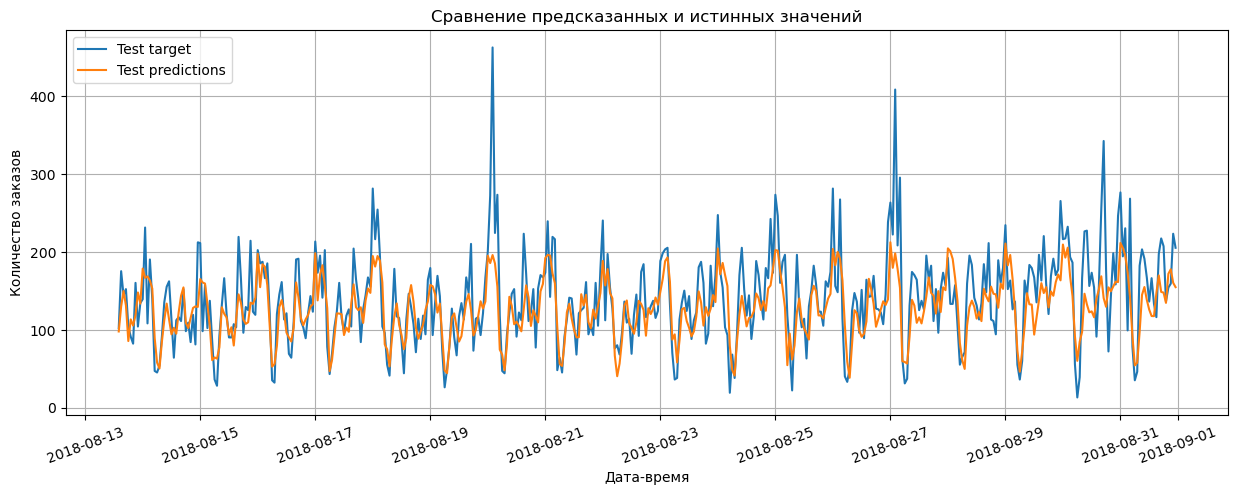

In [29]:
fig, ax = plt.subplots(figsize=(15,5))

df_plot = pd.DataFrame({'target': target_test_gbm.values, \
                        'predictions': pred_gbm, }, index=target_test_gbm.index)
ax.plot(df_plot, label=['Test target', 'Test predictions'])
ax.set_title('Сравнение предсказанных и истинных значений')
ax.tick_params(axis='x', labelrotation = 20)
ax.grid()
ax.set_xlabel('Дата-время')
ax.set_ylabel('Количество заказов')
ax.legend(loc='upper left');

Вывод по графику:

1. Модель хорошо поймала сезонность
2. У предсказанных значений заметно ниже дисперсия, чем у истины. Подозреваю, что это связано с тем, что обилие выбросов приходится на август. Модель такому поведению не научилась.

### 4.2 Сравнение с константной моделью

In [28]:
pred_median = np.ones(test_sarima.shape) * train_sarima['num_orders'].median()
med_res = pd.DataFrame(index=['DummyModel'], data={'RMSE score' : np.sqrt(mean_squared_error(test_sarima, pred_median)), \
                        'R^2 score' : r2_score(test_sarima, pred_median)})

df_res = pd.concat([df_res, med_res])

display(df_res)

,RMSE score,R^2 score
LightGBM,41.869577,0.488614
DummyModel,87.152776,-1.215718


## Итоги исследования:

В ходе исследования построена модель, которая с достаточной точностью предсказывала бы для сервиса заказа такси количество заказов на ближайший час.

Таким образом, исследование состояло из следующих этапов, на каждом из которых формировались выводы, которые попали в итоги работы:  
1. Загрузка, обзор и предобработка данных
2. Ресемплирование и анализ данных
3. Обучение моделей и подбор гиперпараметров
4. Тестирование выбранной модели и проверка ее на адекватность


### Рекомендации в части данных
В ходе исследования отметил высокое качество предоставленных данных, предобработка не потребовалась
  
### Результаты исследования

Для прогнозирования количества заказов на ближайший час предлагаю использовать модель:

* **LGBMRegressor** с параметрами:
    * num_iterations = 50  
    * max_depth = 120
    * num_leaves = 220  
    
Показатели для модели:  

- $RMSE\ score = 41.87$
- $R^2\ score = 0.49$
    